# **Point #2  -  How does weather affect air quality?**

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


2023-08-23 20:11:12.986774: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset
We are using datased with daily moving averages of the features by station (pollutants, weather and AQI index)

In [2]:
df = pd.read_csv('data_daily.csv', parse_dates = ["Date"])
df

,Date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,AQI,target,station_n
0,2013-03-01,8.625000,16.875000,7.375000,44.573821,870.833333,75.791667,1.691667,1024.816667,-19.691667,0.0,2.350000,76.0,4,1
1,2013-03-01,7.541667,12.375000,15.583333,18.731431,362.500000,76.833333,0.016667,1023.783333,-21.941667,0.0,2.933333,77.0,4,2
2,2013-03-01,6.416667,9.875000,8.416667,29.443274,416.666667,71.625000,1.325000,1028.783333,-21.466667,0.0,3.308333,72.0,4,8
3,2013-03-01,6.375000,12.708333,3.000000,34.634057,204.166667,81.958333,0.812500,1023.858333,-19.583333,0.0,2.133333,82.0,4,11
4,2013-03-01,8.041667,10.750000,7.416667,19.609941,350.000000,56.708333,2.062500,1025.904167,-19.708333,0.0,2.608333,57.0,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,2017-02-28,14.875000,32.708333,6.500000,43.871490,570.833333,55.500000,10.958333,1014.887500,-12.783333,0.0,2.058333,56.0,4,3
17528,2017-02-28,23.583333,37.541667,4.083333,32.875000,700.000000,64.583333,8.554167,1009.791667,-10.891667,0.0,2.162500,65.0,4,2
17529,2017-02-28,13.708333,34.000000,5.708333,28.833333,529.166667,41.791667,9.754167,1011.287500,-13.612500,0.0,2.337500,42.0,5,1
17530,2017-02-28,13.125000,22.041667,6.375000,12.276608,412.500000,80.708333,10.187500,1010.116667,-11.704167,0.0,2.350000,81.0,4,11


# Using Association rules to see how wheater affects the AQI

In [4]:
from mlxtend.frequent_patterns import fpgrowth, apriori
from mlxtend.frequent_patterns import association_rules

In [5]:
# Removing pollutants, date and station numbers as they are not significant for this task
columns_to_drop = ['Date', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'AQI', 'station_n']

# Create a new DataFrame by dropping the specified columns from the old DataFrame
df_a = df.drop(columns=columns_to_drop)

# Renaming target colunmnt (contains AQI bucket number)
df_a.rename(columns={'target': 'AQI_bucket'}, inplace=True)

df_a.head(5)

,TEMP,PRES,DEWP,RAIN,WSPM,AQI_bucket
0,1.691667,1024.816667,-19.691667,0.0,2.350000,4
1,0.016667,1023.783333,-21.941667,0.0,2.933333,4
2,1.325000,1028.783333,-21.466667,0.0,3.308333,4
3,0.812500,1023.858333,-19.583333,0.0,2.133333,4
4,2.062500,1025.904167,-19.708333,0.0,2.608333,4


In [6]:
# Binning the weather parameters 
temperature_bins = [-20, -10, 0, 15, 25, 35] 
humidity_bins = [-40, -20, 0, 15, 25, 35]  
wind_speed_bins = [0, 3, 6, 9] 
pressure_bins = [960, 1010, 1020, 1030, 1040, 1050]  
precipitation_bins = [-0.1, 1, 5, 10, 15]  

In [7]:
# Adding new columns with weather paramenter bins
df_a['TemperatureBin'] = pd.cut(df_a['TEMP'], bins=temperature_bins, labels=False)
df_a['HumidityBin'] = pd.cut(df_a['DEWP'], bins=humidity_bins, labels=False)
df_a['WindSpeedBin'] = pd.cut(df_a['WSPM'], bins=wind_speed_bins, labels=False)
df_a['PressureBin'] = pd.cut(df_a['PRES'], bins=pressure_bins, labels=False)
df_a['PrecipitationBin'] = pd.cut(df_a['RAIN'], bins=precipitation_bins, labels=False)


In [8]:
# dropping the weather features to clean up the data
df_a.drop(['TEMP', 'PRES', 'DEWP', 'WSPM', 'RAIN'], axis=1, inplace=True)
df_a.sample(5)

,AQI_bucket,TemperatureBin,HumidityBin,WindSpeedBin,PressureBin,PrecipitationBin
3185,3,2,1,0,1,0
11516,1,3,2,0,1,0
13959,4,3,1,0,1,0
12121,3,2,1,0,2,0
12210,1,2,1,0,2,0


In [9]:
# Binarization (required for the Association rules calculation)
df_encoded = pd.get_dummies(df_a, columns=['AQI_bucket', 'TemperatureBin', 'HumidityBin', 'WindSpeedBin', 'PressureBin', 'PrecipitationBin'])

In [10]:
# Apply Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

rules.sample(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
16,(HumidityBin_3),(PrecipitationBin_0),0.244924,0.985569,0.232888,0.950862,0.964784,-0.008501,0.293676,-0.046112
71,"(HumidityBin_1, TemperatureBin_2)","(PrecipitationBin_0, WindSpeedBin_0)",0.256388,0.911932,0.229523,0.895217,0.981670,-0.004286,0.840475,-0.024495
45,"(TemperatureBin_3, PressureBin_0)",(PrecipitationBin_0),0.233288,0.985569,0.224276,0.961369,0.975446,-0.005646,0.373556,-0.031788
29,(AQI_bucket_4),"(PrecipitationBin_0, WindSpeedBin_0)",0.340235,0.911932,0.289585,0.851132,0.933327,-0.020687,0.591580,-0.097696
10,(HumidityBin_1),(WindSpeedBin_0),0.404175,0.925793,0.356947,0.883150,0.953939,-0.017235,0.635063,-0.074964
51,"(HumidityBin_2, WindSpeedBin_0)",(PrecipitationBin_0),0.295916,0.985569,0.293806,0.992868,1.007406,0.002160,2.023426,0.010441
62,"(PressureBin_0, PrecipitationBin_0)",(WindSpeedBin_0),0.471138,0.925793,0.451745,0.958838,1.035694,0.015569,1.802798,0.065166
7,(TemperatureBin_3),(WindSpeedBin_0),0.309662,0.925793,0.292893,0.945846,1.021661,0.006210,1.370308,0.030712
14,(HumidityBin_3),(WindSpeedBin_0),0.244924,0.925793,0.244182,0.996973,1.076885,0.017434,24.511197,0.094554
5,(TemperatureBin_2),(WindSpeedBin_0),0.351586,0.925793,0.319188,0.907852,0.980621,-0.006308,0.805305,-0.029576


In [11]:
# Filter rules that involve AQI in consequent to see if weather affects AQI.
aqi_rules = rules[rules['consequents'].astype(str).str.contains('AQI_bucket')]
aqi_rules.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         0 non-null      object 
 1   consequents         0 non-null      object 
 2   antecedent support  0 non-null      float64
 3   consequent support  0 non-null      float64
 4   support             0 non-null      float64
 5   confidence          0 non-null      float64
 6   lift                0 non-null      float64
 7   leverage            0 non-null      float64
 8   conviction          0 non-null      float64
 9   zhangs_metric       0 non-null      float64
dtypes: float64(8), object(2)
memory usage: 0.0+ bytes


*If AQI does not appear in the consequent part of the association rules, it means that the association rule mining did not find any strong relationships between specific weather parameter combinations (in the antecedent) and specific AQI levels (in the consequent)*. 

In other words, the discovered rules suggest that the presence or absence of certain weather conditions does not directly lead to specific AQI levels.

However, this does not necessarily mean that weather has no influence on AQI. It could indicate one of the following scenarios:

**Weak Association**: The dataset used for association rule mining may not contain strong patterns or correlations between the weather parameters and AQI levels. In such cases, the algorithm may not find any significant associations between them.

**Indirect Influence**: While the association rule mining may not show direct relationships between specific weather conditions and AQI levels, weather can still have an indirect influence on air quality. For example, weather conditions can impact air pollution sources (e.g., traffic emissions, industrial activities) or the dispersion and accumulation of pollutants, which, in turn, affect AQI levels.

**Complex Interactions**: Air quality is influenced by multiple factors, including weather, emissions, atmospheric conditions, and geographical factors. The relationship between weather and AQI can be complex and may not be captured effectively by simple association rule mining.

# Choose, scale and split the data into training and testing sets

In [12]:
X = df[['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']]
y = df['AQI']

In [13]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,TEMP,PRES,DEWP,RAIN,WSPM
0,-1.094305,1.369612,-1.637273,-0.194385,0.788365
1,-1.248985,1.268994,-1.803427,-0.194385,1.535712
2,-1.128165,1.755858,-1.768350,-0.194385,2.016148
3,-1.175492,1.276297,-1.629273,-0.194385,0.510780
4,-1.060060,1.475505,-1.638503,-0.194385,1.119333
...,...,...,...,...,...
17527,-0.238563,0.402782,-1.127118,-0.194385,0.414692
17528,-0.460578,-0.093414,-0.987425,-0.194385,0.548147
17529,-0.349763,0.052240,-1.188349,-0.194385,0.772351
17530,-0.309746,-0.061767,-1.047425,-0.194385,0.788365


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regression

In [15]:
RF = RandomForestRegressor(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

In [16]:
# Calculate evaluation metrics
mse_RF = mean_squared_error(y_test, y_pred)
r2_RF = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error_Random Forest Regression:", mse_RF)
print("R-squared_Random Forest Regression:", r2_RF)

Mean Squared Error_Random Forest Regression: 2861.578987949755
R-squared_Random Forest Regression: 0.7715760846972621


# Neural Network

In [17]:
# Define your neural network model
NN_model = Sequential([
    Dense(units=64, activation='relu', input_shape=(X_train.shape[1], 1)),
    #Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanSquaredError()])

# Print the model summary
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5, 64)             128       
                                                                 
 dense_1 (Dense)             (None, 5, 1)              65        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
351/351 [==============================] - 3s 3ms/step - loss: 40292.8984 - mean_squared_error: 40292.8984 - val_loss: 40614.7695 - val_mean_squared_error: 40614.7695
Epoch 2/100
351/351 [==============================] - 1s 1ms/step - loss: 40247.7812 - mean_squared_error: 40247.7812 - val_loss: 40611.3984 - val_mean_squared_error: 40611.3984
Epoch 3/100
351/351 [==============================] - 0s 1ms/step - loss: 40246.4570 - mean_squared_error: 40246.4570 - val_loss: 40610.8867 - val_mean_squared_error: 40610.8867
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 40246.1484 - mean_squared_error: 40246.1484 - val_loss: 40610.7383 - val_mean_squared_error: 40610.7383
Epoch 5/100
351/351 [==============================] - 0s 1ms/step - loss: 40246.0391 - mean_squared_error: 40246.0391 - val_loss: 40610.6562 - val_mean_squared_error: 40610.6562
Epoch 6/100
351/351 [==============================] - 0s 1ms/step - loss: 40245.9766 - mean_squared_erro

In [19]:
# Make predictions
predictions = NN_model.predict(X_test)

# Evaluate the model
loss, metric_value = NN_model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Metric value:", metric_value)

110/110 [==============================] - 0s 962us/step - loss: 39714.2109 - mean_squared_error: 39714.2109
Loss: 39714.2109375
Metric value: 39714.2109375


In [20]:

# Calculate evaluation metrics
mse_NN = mean_squared_error(y_test, y_pred)
r2_NN = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error_Long Short-Term Memory Network:", mse_NN)
print("R-squared_Long Short-Term Memory Network:", r2_NN)

Mean Squared Error_Long Short-Term Memory Network: 2861.578987949755
R-squared_Long Short-Term Memory Network: 0.7715760846972621


# XGBoost Regression

In [21]:
XGB = XGBRegressor(random_state=42)
XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [22]:
y_pred = XGB.predict(X_test)
# Calculate evaluation metrics
mse_XGB = mean_squared_error(y_test, y_pred)
r2_XGB = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error_XGBoost Regression:", mse_XGB)
print("R-squared_XGBoost Regression:", r2_XGB)

Mean Squared Error_XGBoost Regression: 4105.387138890066
R-squared_XGBoost Regression: 0.6722898064153524


# Build table comparing model results

In [23]:
model_names = ['Random Forest Regression', 'Neural Network', 'XGBoost Regression']
mse_scores = [mse_RF, mse_NN, mse_XGB]
r2_scores = [r2_RF, r2_NN, r2_XGB]

In [24]:
evaluation_results = {
    'Model': model_names,
    'MSE': mse_scores,
    'R2': r2_scores
}
results_df = pd.DataFrame(evaluation_results)
# Round the float cells to 2 decimal places
results_df['MSE'] = results_df['MSE'].apply(lambda x: round(x, 0))
results_df['R2'] = results_df['R2'].apply(lambda x: round(x, 3))

print(results_df)
results_df.to_csv('model_evaluation_results.csv', index=False)

                      Model     MSE     R2
0  Random Forest Regression  2862.0  0.772
1            Neural Network  2862.0  0.772
2        XGBoost Regression  4105.0  0.672


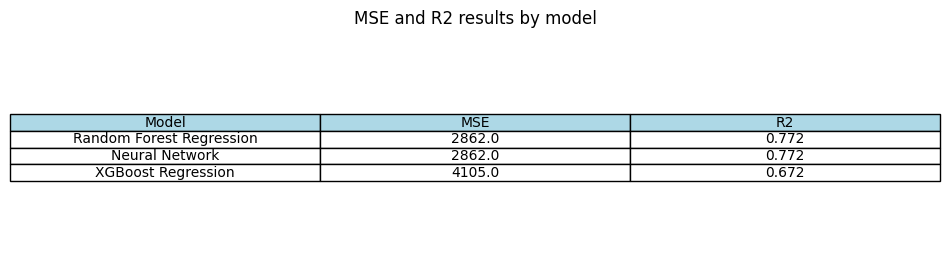

In [25]:
# Plotting the table within the code
def plot_table(dataframe):
    # Get column names and data from the DataFrame
    columns = dataframe.columns
    cell_text = []
    for row in dataframe.values:
        cell_text.append(row)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 3))

    # Hide axes
    ax.axis('off')

    # Create a table
    table = ax.table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='center', colColours=['lightblue']*len(columns))

    # Add a title to the table
    ax.set_title('MSE and R2 results by model', fontsize=12)

    # Show the table plot
    plt.show()

# Call the function with your DataFrame
plot_table(results_df)

Clearly Random Forest Regression is showing best results. Now we will try to tweak the RF model even more by searching for best parameters.

# Best Parameters for Random Forest Model

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt', None],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=

results after  13 min (previosly with hourly data set it took 292 min with same result):
Fitting 5 folds for each of 162 candidates, totalling 810 fits


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

All default besides n_estimators.

In [28]:
# now trying to fit the model with the best parameters
best_rf_model = grid_search.best_estimator_

# fitting the moddel with these parameters
best_rf_model.fit(X_train, y_train)

# and predicting
y_pred = best_rf_model.predict(X_test)

In [29]:
best_MSE = mean_squared_error(y_test, y_pred)
best_R2 = r2_score(y_test, y_pred)
print("Best MSE:", best_MSE)
print("Best R-squared:", best_R2)

Best MSE: 2833.828648847298
Best R-squared: 0.7737912397342033


# **Calculating most important features for the Random Forest model**

In [30]:
# Calculate feature importance
feature_importance = best_rf_model.feature_importances_  

# Print feature importance scores
print("Feature Importance:")
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")

Feature Importance:
TEMP: 0.2570
PRES: 0.1619
DEWP: 0.2744
RAIN: 0.0585
WSPM: 0.2481


In [31]:
# Calculate permutation importance manually
def calculate_permutation_importance(model, X, y_true, n_iterations=100):
    baseline_error = mean_squared_error(y_true, model.predict(X))
    importance_scores = []
    for feature in X.columns:
        X_permuted = X.copy()
        errors = []
        for _ in range(n_iterations):
            X_permuted[feature] = np.random.permutation(X[feature].values)
            y_pred = model.predict(X_permuted)
            error = mean_squared_error(y_true, y_pred)
            errors.append(error)
        importance = baseline_error - np.mean(errors)
        importance_scores.append(importance)
    return importance_scores

perm_importance = calculate_permutation_importance(best_rf_model, X_test, y_test)

# Print permutation importance scores
print("\nPermutation Importance:")
for feature, importance in zip(X.columns, perm_importance):
    print(f"{feature}: {importance:.4f}")


Permutation Importance:
TEMP: -11981.1756
PRES: -3898.8007
DEWP: -9515.4108
RAIN: -1715.5061
WSPM: -4725.6265


From the results we can state that our model most relies on **temperature**, **pressure**, **wind speed** and **dew point tempererature** in predicting AQI. Rainfall is least important for model's predictions.

**VISUALIZATION** 

Ploting the correlations between different weather features and AQI

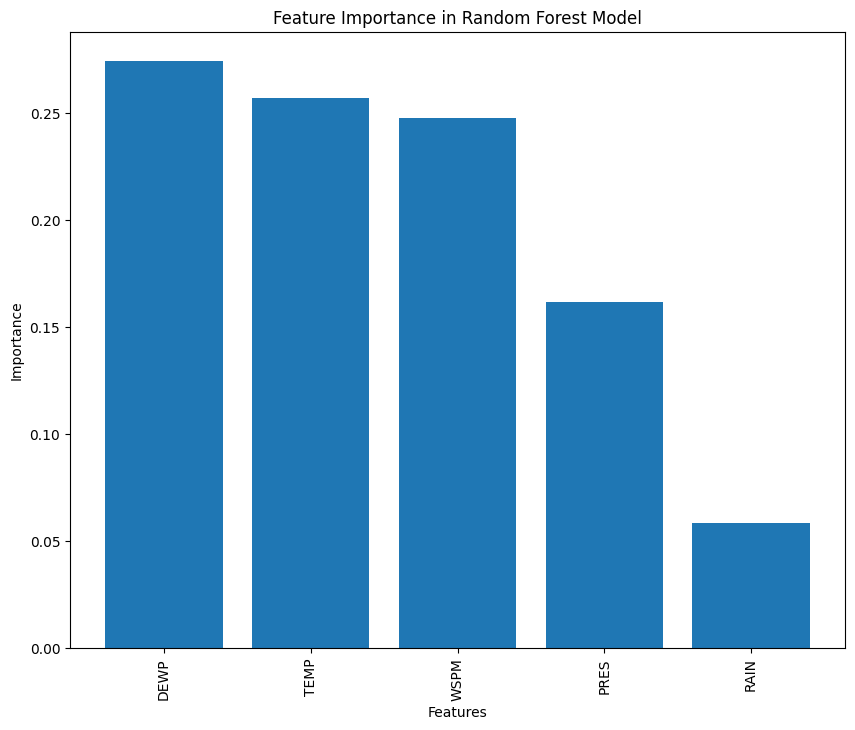

In [32]:
# Create a DataFrame to store feature importances and their corresponding column names
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

# Sort the features by their importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

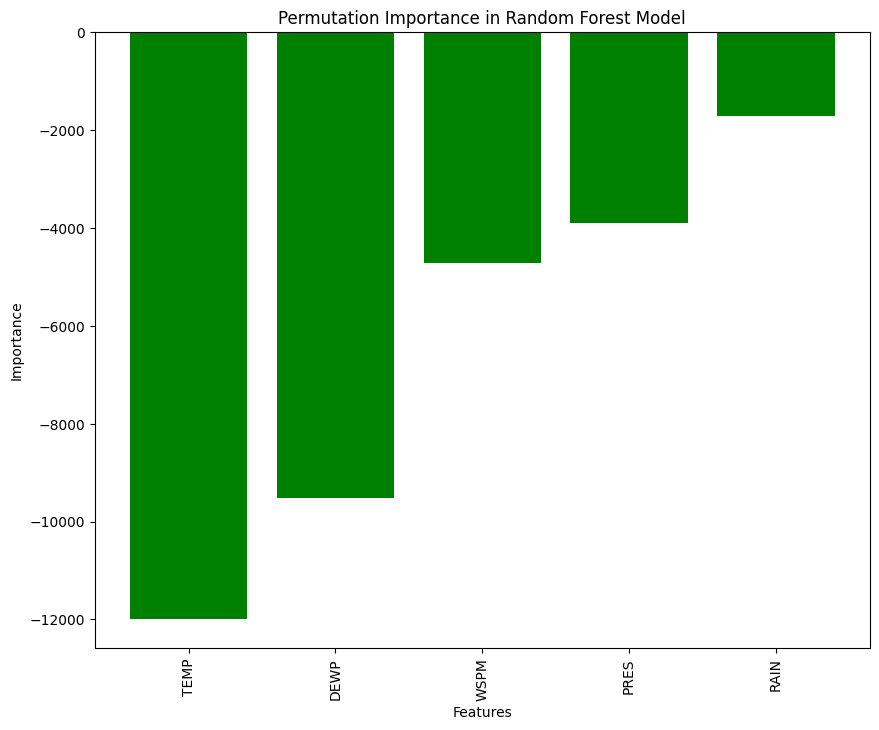

In [33]:
# Create a DataFrame to store permutation importances and their corresponding column names
perm_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': perm_importance})

# Sort the features by their importance scores in descending order
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.bar(perm_importance_df['Feature'], perm_importance_df['Importance'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Permutation Importance in Random Forest Model')
plt.show()